In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle as pk

sns.set()
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
with open('../input/pickles/df_cob.pkl', 'rb') as f:
    df_cob = pk.load(f)

In [14]:
df_cob['Probabilidades'] = df_cob['Probabilidades'] * 100

# Como vou trabalhar apenas com um subconjunto do original, nem todas as categorias de cada variável
# estão presentes
to_string_fields = ['DESC_TIP_LANC', 'DESC_TIP_CTBU_ORIG', 'DESC_TIP_DEB', 'COD_SSIS_ORIG',
                   'COD_TIP_ATLZ_DEB', 'MES']
for i in to_string_fields:
        df_cob[i] = df_cob[i].astype(str)

df_cob.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900846 entries, 13 to 2739772
Data columns (total 14 columns):
COD_DEB                     category
COD_SSIS_ORIG               object
COD_TIP_ATLZ_DEB            object
DESC_TIP_CTBU_ORIG          object
DESC_TIP_DEB                object
DESC_TIP_LANC               object
MES                         object
debitos_contribuinte        float64
dias_ate_pagar              float64
target                      category
PRINCIPAL                   float64
log_principal               float64
log_debitos_contribuinte    float64
Probabilidades              float64
dtypes: category(2), float64(6), object(6)
memory usage: 217.4+ MB


## Perguntas

1. Dentre os que ainda não pagaram, qual a distribuição das porcentagens, qual retorno pode-se esperar?
2. Existem alguma similaridade perceptível entre aqueles com menor chance de pagar seus débitos?

In [15]:
# Não pagantes - aqueles com débitos em aberto
n_pag = df_cob[df_cob.COD_TIP_ATLZ_DEB.isin(['I', 'A'])]

# Pagantes
pag = df_cob[df_cob.COD_TIP_ATLZ_DEB == 'N']

(n_pag.shape[0], pag.shape[0])

(771956, 1128890)

### Pergunta 1

** Dentre os que ainda não pagaram, qual a distribuição das porcentagens, qual retorno pode-se esperar? **

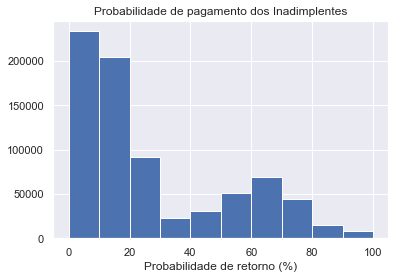

In [16]:
plt.hist(n_pag.Probabilidades)
plt.title('Probabilidade de pagamento dos Inadimplentes')
plt.xlabel('Probabilidade de retorno (%)')
plt.show()

In [17]:
# Darei como maior chance de retorno aqueles com probabilidade maior que 60%
top_proba = n_pag[n_pag.Probabilidades > 60].copy()
print('Quantidade de débitos em aberto com maior chance de retorno: {}'.format(top_proba.shape[0]))
print('Quantia total do principal: R$ {:.2f}'.format(top_proba.PRINCIPAL.sum()))

Quantidade de débitos em aberto com maior chance de retorno: 137352
Quantia total do principal: R$ 76678006.65


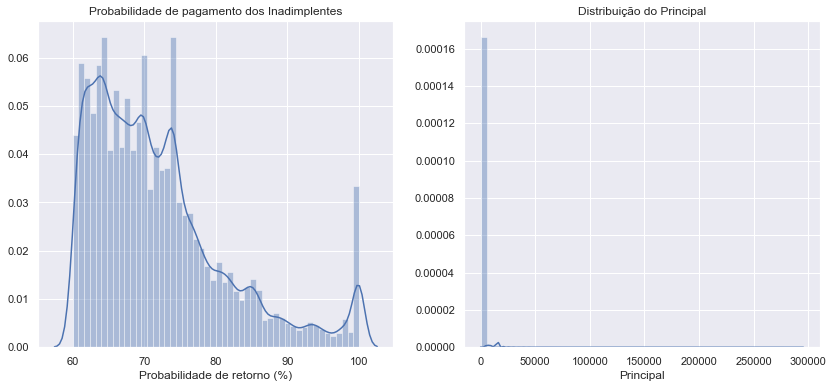

In [18]:
sns.set(rc={'figure.figsize':(14,6)})

plt.subplot(1,2,1)
sns.distplot(top_proba.Probabilidades)
plt.title('Probabilidade de pagamento dos Inadimplentes')
plt.xlabel('Probabilidade de retorno (%)')

plt.subplot(1,2,2)
sns.distplot(top_proba.PRINCIPAL)
plt.title('Distribuição do Principal')
plt.xlabel('Principal')

plt.show()

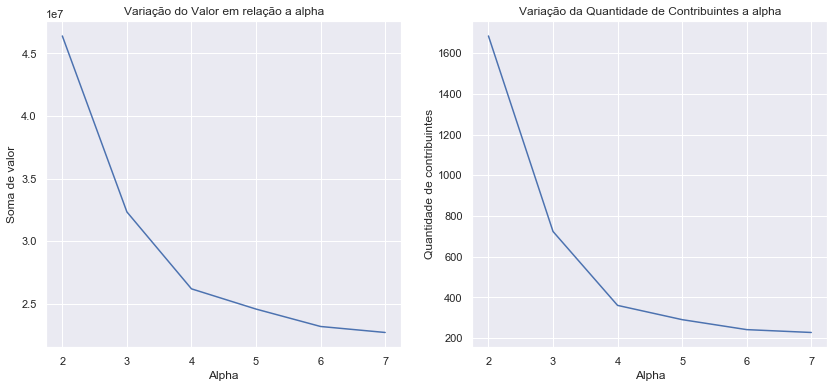

In [29]:
# Possui muitos outliers, quem são esses outliers?
desvio = top_proba.PRINCIPAL.std()
media = top_proba.PRINCIPAL.mean()

alphas = [2, 3, 4, 5, 6, 7]
quantias = []
regs = []
for i in alphas:
    lim_max = media + i * desvio
    outliers = top_proba.PRINCIPAL > lim_max
    
    q = top_proba[outliers].PRINCIPAL.sum()
    quantias.append(q)
    
    r = top_proba[outliers].shape[0]
    regs.append(r)
    

sns.set(rc={'figure.figsize':(14,6)})

plt.subplot(1,2,1)
sns.lineplot(x=alphas, y=quantias)
plt.title('Variação do Valor em relação a alpha')
plt.xlabel('Alpha')
plt.ylabel('Soma de valor')

plt.subplot(1,2,2)
sns.lineplot(x=alphas, y=regs)
plt.title('Variação da Quantidade de Contribuintes a alpha')
plt.xlabel('Alpha')
plt.ylabel('Quantidade de contribuintes')

plt.show()

In [27]:
# Quanto os outliers representam no total
desvio = top_proba.PRINCIPAL.std()
media = top_proba.PRINCIPAL.mean()
lim_max = media + 4 * desvio
outliers = top_proba.PRINCIPAL > lim_max

out_rep = top_proba[outliers].PRINCIPAL.sum() / top_proba.PRINCIPAL.sum()
print('Quantidade de outliers: {}'.format(top_proba[outliers].shape[0]))
print('Os outliers representam {:.2f} % do total do principal'.format(out_rep * 100))
print('Quantia concentrada nos outliers: R$ {:.2f}'.format(top_proba[outliers].PRINCIPAL.sum()))

Quantidade de outliers: 361
Os outliers representam 34.15 % do total do principal
Quantia concentrada nos outliers: R$ 26183443.89


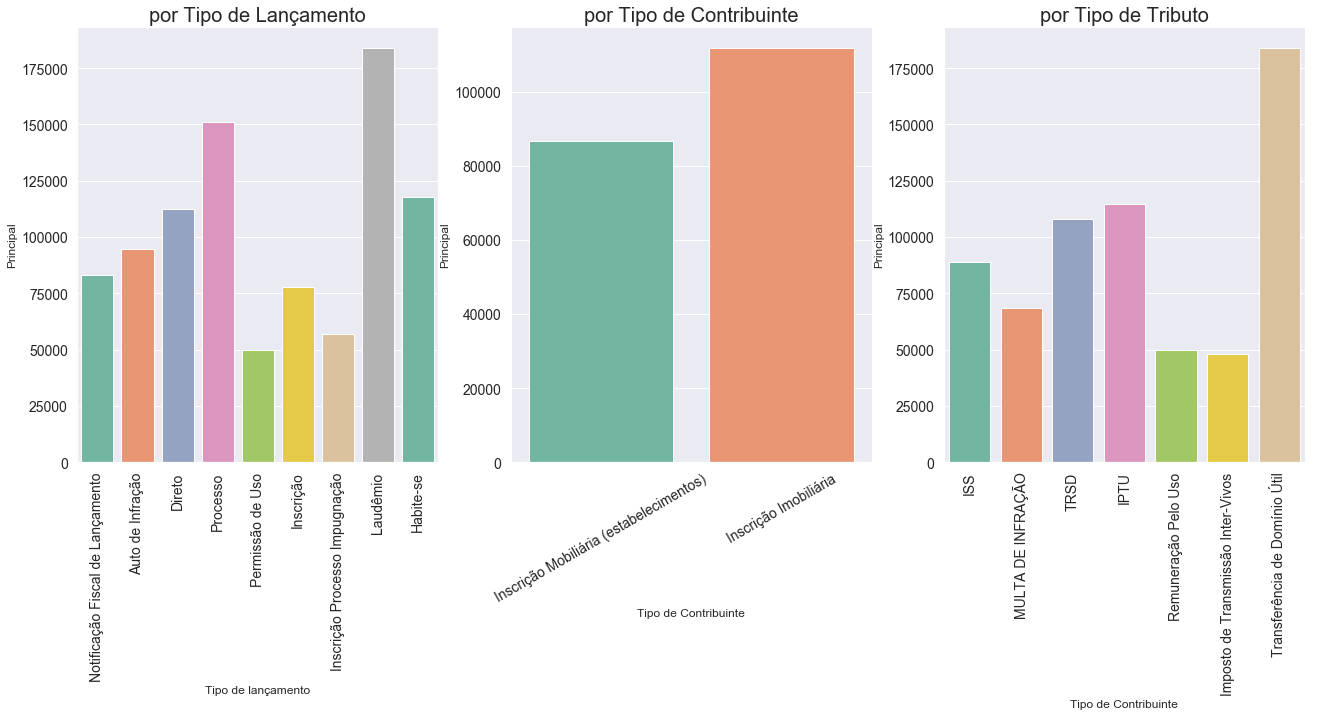

In [36]:
# Entendendo melhor esses contribuintes
sns.set(rc={'figure.figsize':(22,8)})


plt.subplot(1,3,1)
g = sns.barplot(x=top_proba[outliers].DESC_TIP_LANC, y=top_proba[outliers].PRINCIPAL, 
                ci=None, palette='Set2')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.tick_params(labelsize=14)
g.axes.set_title("por Tipo de Lançamento",fontsize=20)
plt.xlabel('Tipo de lançamento')
plt.ylabel('Principal')

plt.subplot(1,3,2)
g = sns.barplot(x=top_proba[outliers].DESC_TIP_CTBU_ORIG, y=top_proba[outliers].PRINCIPAL,
                ci=None, palette='Set2')
g.set_xticklabels(g.get_xticklabels(),rotation=30)
g.tick_params(labelsize=14)
g.axes.set_title("por Tipo de Contribuinte",fontsize=20)
plt.xlabel('Tipo de Contribuinte')
plt.ylabel('Principal')

plt.subplot(1,3,3)
g = sns.barplot(x=top_proba[outliers].DESC_TIP_DEB, y=top_proba[outliers].PRINCIPAL,
                ci=None, palette='Set2')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.tick_params(labelsize=14)
g.axes.set_title("por Tipo de Tributo",fontsize=20)
plt.xlabel('Tipo de Contribuinte')
plt.ylabel('Principal')

plt.show()

### Pergunta 2

Existem alguma similaridade perceptível entre aqueles com menor chance de pagar seus débitos?
1. Usar um cluster para agrupar os débitos
2. Dentre os clusters, verificar aquele com a menor média de probabilidade
3. Usar gráficos e proporções para tentar encontrar algo útil

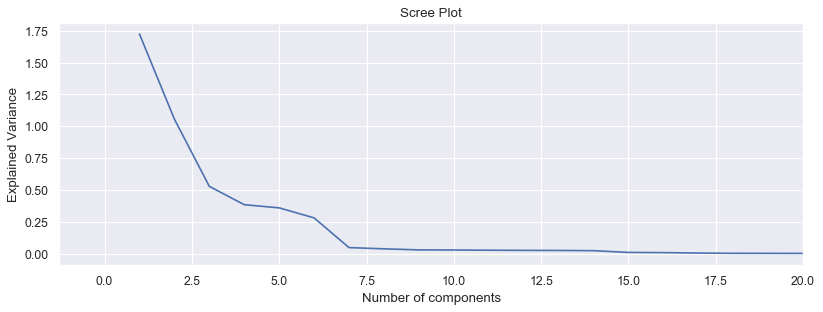

In [38]:
# Removerei do cluster as variáveis log_principal
# motivo: diminuir a correlação existente com a variável Probabilidades

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

cluster_X = n_pag.drop(['COD_TIP_ATLZ_DEB', 'COD_DEB', 'dias_ate_pagar', 'target',
                       'PRINCIPAL', 'debitos_contribuinte', 'log_principal'], axis=1)

cluster_X['log_debitos_contribuinte'] = StandardScaler().fit_transform(cluster_X['log_debitos_contribuinte'].values.reshape(-1,1))
cluster_X['Probabilidades'] = StandardScaler().fit_transform(cluster_X['Probabilidades'].values.reshape(-1,1))
# cluster_X['log_principal'] = StandardScaler().fit_transform(cluster_X['log_principal'].values.reshape(-1,1))

cluster_X = pd.get_dummies(cluster_X)

pca = PCA(n_components=cluster_X.shape[1])
pca.fit(cluster_X)

plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')

plt.plot([x for x in range(1,cluster_X.shape[1]+1)], pca.explained_variance_) 
plt.title('Scree Plot')
plt.xlabel('Number of components')
plt.ylabel('Explained Variance')
plt.xlim(xmax=20)
plt.show()

In [39]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

pca_clt = PCA(n_components=7).fit_transform(cluster_X)
X_train, X_test = train_test_split(pca_clt, test_size=0.2, random_state=42)

In [40]:
scores = []
centers_matrix = []
sample_preds = []

for n_cpt in range(2, 20, 2):
    #clusterer = GaussianMixture(n_components=n_cpt, random_state=42).fit(X_train)
    clusterer = KMeans(n_clusters=n_cpt, random_state=42).fit(X_train)
    preds = clusterer.predict(X_test)
    
    score = silhouette_score(X_test, preds, random_state=42, sample_size=int(1e3))
    scores.append(score)

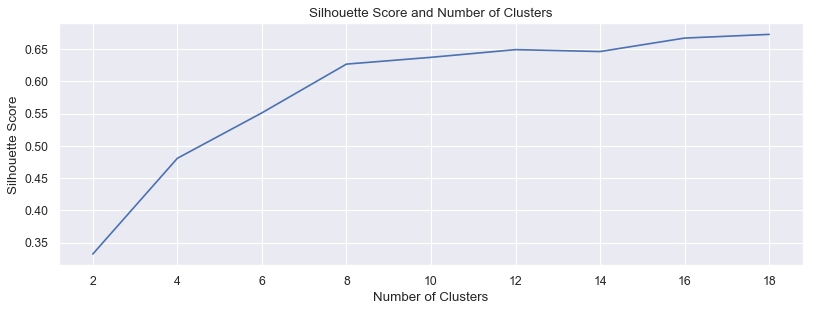

In [41]:
plt.figure(figsize=(12, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(range(2, 20, 2,), scores)
plt.title('Silhouette Score and Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [45]:
clusterer = KMeans(n_clusters=8, random_state=42).fit(X_train)
preds = clusterer.predict(pca_clt)

clt = n_pag.copy()
clt['cluster'] = preds

clt_group  = clt.groupby(['cluster']).aggregate({'Probabilidades':'mean',
                                     'COD_DEB':'count'}).reset_index().sort_values(['Probabilidades'])
clt_group.rename({'COD_DEB':'Quantidae de contribuintes', 'Probabilidades':'Média da Probabilidade'}, axis=1, inplace=True)
clt_group

,cluster,Média da Probabilidade,Quantidae de contribuintes
3,3,4.822548,104635
5,5,6.254999,102136
4,4,15.501933,100014
6,6,16.515029,83726
0,0,22.402873,86988
1,1,24.619287,105686
2,2,66.189924,142311
7,7,67.843524,46460


#### O cluster 2 e 15, apresentaram médias de probabilidade muito baixas

In [46]:
aux = clt[clt.cluster.isin([3])].copy()

In [47]:
def get_props(df_main, df_aux, field):
    temp1 = clt.groupby([field]).COD_DEB.count().reset_index()
    temp2 = aux.groupby([field]).COD_DEB.count().reset_index()
    temp = temp1.merge(temp2, on=field, how='inner')
    temp['p'] = (temp['COD_DEB_y'] / temp['COD_DEB_x']) * 100

    g = sns.barplot(x=temp[field], y=temp.p, 
                ci=None, palette='Set2')
    g.set_xticklabels(g.get_xticklabels(),rotation=90)
    g.tick_params(labelsize=14)
 
    return g

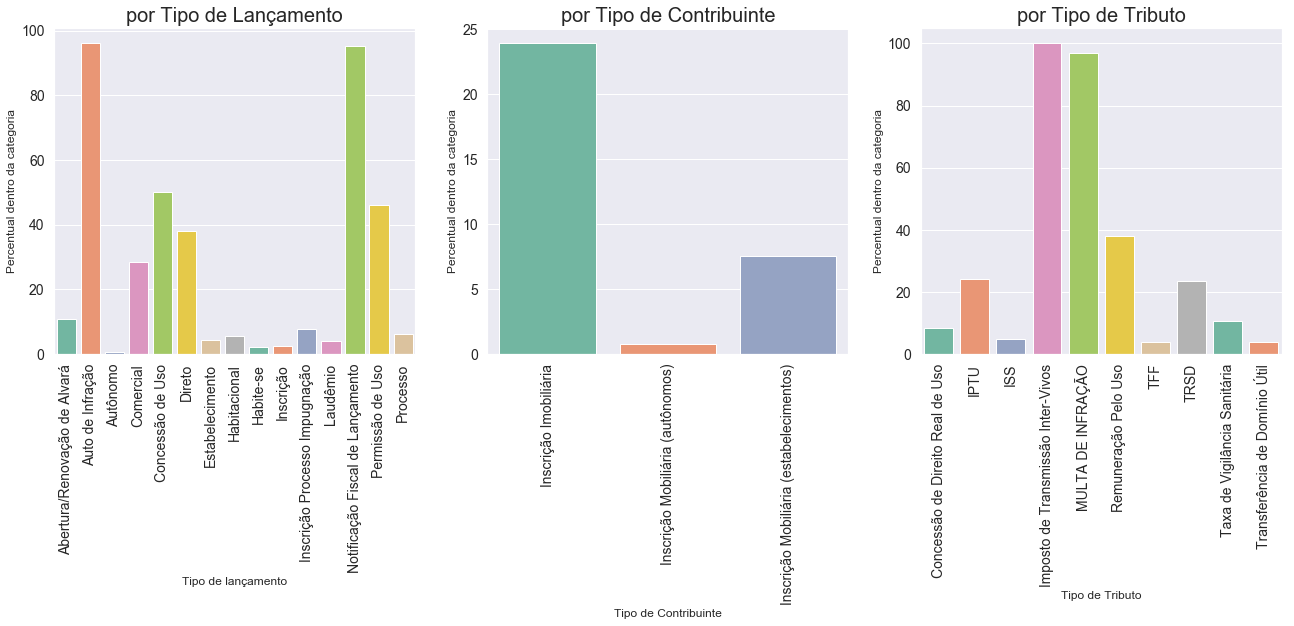

In [49]:
aux = clt[clt.cluster.isin([2,15])].copy()

sns.set(rc={'figure.figsize':(22,6)})

plt.subplot(1,3,1)
g = get_props(clt, aux, 'DESC_TIP_LANC')
g.axes.set_title("por Tipo de Lançamento",fontsize=20)
plt.xlabel('Tipo de lançamento')
plt.ylabel('Percentual dentro da categoria')

plt.subplot(1,3,2)
g = get_props(clt, aux, 'DESC_TIP_CTBU_ORIG')
g.axes.set_title("por Tipo de Contribuinte",fontsize=20)
plt.xlabel('Tipo de Contribuinte')
plt.ylabel('Percentual dentro da categoria')

plt.subplot(1,3,3)
g = get_props(clt, aux, 'DESC_TIP_DEB')
g.axes.set_title("por Tipo de Tributo",fontsize=20)
plt.xlabel('Tipo de Tributo')
plt.ylabel('Percentual dentro da categoria')


plt.show()

#### E para os débitos mais saudáveis?

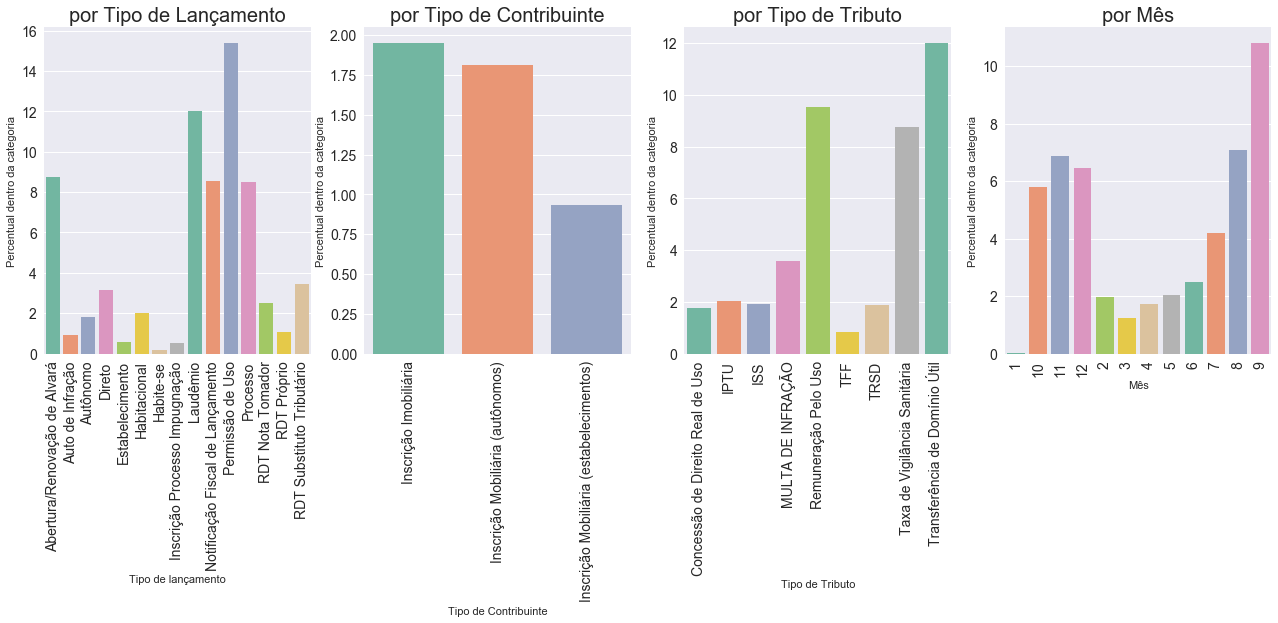

In [66]:
aux = clt[clt.cluster == 13].copy()

sns.set(rc={'figure.figsize':(22,6)})

plt.subplot(1,4,1)
g = get_props(clt, aux, 'DESC_TIP_LANC')
g.axes.set_title("por Tipo de Lançamento",fontsize=20)
plt.xlabel('Tipo de lançamento')
plt.ylabel('Percentual dentro da categoria')

plt.subplot(1,4,2)
g = get_props(clt, aux, 'DESC_TIP_CTBU_ORIG')
g.axes.set_title("por Tipo de Contribuinte",fontsize=20)
plt.xlabel('Tipo de Contribuinte')
plt.ylabel('Percentual dentro da categoria')

plt.subplot(1,4,3)
g = get_props(clt, aux, 'DESC_TIP_DEB')
g.axes.set_title("por Tipo de Tributo",fontsize=20)
plt.xlabel('Tipo de Tributo')
plt.ylabel('Percentual dentro da categoria')

plt.subplot(1,4,4)
g = get_props(clt, aux, 'MES')
g.axes.set_title("por Mês",fontsize=20)
plt.xlabel('Mês')
plt.ylabel('Percentual dentro da categoria')

plt.show()